# Cavity flow with Navier-Stokes

The final two steps will both solve the Navier–Stokes equations in two dimensions, but with different boundary conditions.

The momentum equation in vector form for a velocity field v⃗ 

is:

$$ \frac{\partial \overrightarrow{v}}{\partial t} + (\overrightarrow{v} \cdot \nabla ) \overrightarrow{v} = -\frac{1}{\rho}\nabla p + \nu \nabla^2 \overrightarrow{v}$$

This represents three scalar equations, one for each velocity component (u,v,w). But we will solve it in two dimensions, so there will be two scalar equations.

Remember the continuity equation? This is where the Poisson equation for pressure comes in!

Here is the system of differential equations: two equations for the velocity components u,v and one equation for pressure:

$$ \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y}= -\frac{1}{\rho}\frac{\partial p}{\partial x}  + \nu \left[ \frac{\partial^2 u}{\partial x^2} +\frac{\partial^2 u}{\partial y^2} \right] $$

$$ \frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y}= -\frac{1}{\rho}\frac{\partial p}{\partial y}  + \nu \left[ \frac{\partial^2 v}{\partial x^2} +\frac{\partial^2 v}{\partial y^2} \right] $$

$$
\frac{\partial^2 p}{\partial x^2} +\frac{\partial^2 p}{\partial y^2} =
\rho \left[\frac{\partial}{\partial t} \left(\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} \right) - \left(\frac{\partial u}{\partial x}\frac{\partial u}{\partial x}+2\frac{\partial u}{\partial y}\frac{\partial v}{\partial x}+\frac{\partial v}{\partial y}\frac{\partial v}{\partial y} \right) \right]
$$

From the previous steps, we already know how to discretize all these terms. Only the last equation is a little unfamiliar. But with a little patience, it will not be hard!


Our stencils look like this:
First the momentum equation in the u direction
$$
\begin{split}
u_{i,j}^{n+1} = u_{i,j}^{n} & - u_{i,j}^{n} \frac{\Delta t}{\Delta x} \left(u_{i,j}^{n}-u_{i-1,j}^{n}\right) - v_{i,j}^{n} \frac{\Delta t}{\Delta y} \left(u_{i,j}^{n}-u_{i,j-1}^{n}\right) \\
& - \frac{\Delta t}{\rho 2\Delta x} \left(p_{i+1,j}^{n}-p_{i-1,j}^{n}\right) \\
& + \nu \left(\frac{\Delta t}{\Delta x^2} \left(u_{i+1,j}^{n}-2u_{i,j}^{n}+u_{i-1,j}^{n}\right) + \frac{\Delta t}{\Delta y^2} \left(u_{i,j+1}^{n}-2u_{i,j}^{n}+u_{i,j-1}^{n}\right)\right)
\end{split}
$$
Second the momentum equation in the v direction
$$
\begin{split}
v_{i,j}^{n+1} = v_{i,j}^{n} & - u_{i,j}^{n} \frac{\Delta t}{\Delta x} \left(v_{i,j}^{n}-v_{i-1,j}^{n}\right) - v_{i,j}^{n} \frac{\Delta t}{\Delta y} \left(v_{i,j}^{n}-v_{i,j-1}^{n})\right) \\
& - \frac{\Delta t}{\rho 2\Delta y} \left(p_{i,j+1}^{n}-p_{i,j-1}^{n}\right) \\
& + \nu \left(\frac{\Delta t}{\Delta x^2} \left(v_{i+1,j}^{n}-2v_{i,j}^{n}+v_{i-1,j}^{n}\right) + \frac{\Delta t}{\Delta y^2} \left(v_{i,j+1}^{n}-2v_{i,j}^{n}+v_{i,j-1}^{n}\right)\right)
\end{split}
$$
Finally the pressure-Poisson equation
$$\begin{split}
p_{i,j}^{n} = & \frac{\left(p_{i+1,j}^{n}+p_{i-1,j}^{n}\right) \Delta y^2 + \left(p_{i,j+1}^{n}+p_{i,j-1}^{n}\right) \Delta x^2}{2\left(\Delta x^2+\Delta y^2\right)} \\
& -\frac{\rho\Delta x^2\Delta y^2}{2\left(\Delta x^2+\Delta y^2\right)} \\
& \times \left[\frac{1}{\Delta t}\left(\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}+\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\right)-\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}\right. \\ 
& \left. -2\frac{u_{i,j+1}-u_{i,j-1}}{2\Delta y}\frac{v_{i+1,j}-v_{i-1,j}}{2\Delta x}-\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y} \right] 
\end{split}
$$

The initial condition is $u,v,p=0$

everywhere, and the boundary conditions are:

$u=1$ at $y=1$ (the "lid");

$u,v=0$ on the other boundaries;

$\frac{\partial p}{\partial y}=0$ at $y=0,1$;

$\frac{\partial p}{\partial x}=0$ at $x=0,1$

$p=0$ at $(0,0)$

Interestingly these boundary conditions describe a well known problem in the Computational Fluid Dynamics realm, where it is known as the lid driven square cavity flow problem.

## Numpy Implementation

In [1]:
import numpy as np
from matplotlib import pyplot, cm
%matplotlib inline

In [2]:
nx = 41
ny = 41
nt = 1000
nit = 50
c = 1
dx = 1. / (nx - 1)
dy = 1. / (ny - 1)
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
Y, X  = np.meshgrid(x, y)

rho = 1
nu = .1
dt = .001

u = np.zeros((nx, ny))
v = np.zeros((nx, ny))
p = np.zeros((nx, ny)) 

The pressure Poisson equation that's written above can be hard to write out without typos. The function `build_up_b` below represents the contents of the square brackets, so that the entirety of the Poisson pressure equation is slightly more manageable.

In [3]:
def build_up_b(b, rho, dt, u, v, dx, dy):
    
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[2:, 1:-1] - u[0:-2, 1:-1]) / 
                     (2 * dx) + (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dy)) -
                    ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dx))**2 -
                      2 * ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dy) *
                           (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dx))-
                          ((v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dy))**2))

    return b

The function `pressure_poisson` is also defined to help segregate the different rounds of calculations. Note the presence of the pseudo-time variable nit. This sub-iteration in the Poisson calculation helps ensure a divergence-free field.

In [4]:
def pressure_poisson(p, dx, dy, b):
    pn = np.empty_like(p)
    pn = p.copy()
    
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dy**2 + 
                          (pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])
        
        p[-1, :] = p[-2, :] # dp/dx = 0 at x = 2
        p[:, 0] = p[:, 1]   # dp/dy = 0 at y = 0
        p[0, :] = p[1, :]   # dp/dx = 0 at x = 0
        p[:, -1] = p[:, -2]    # p = 0 at y = 2
        p[0, 0] = 0 
        
    return p, pn

Finally, the rest of the cavity flow equations are wrapped inside the function `cavity_flow`, allowing us to easily plot the results of the cavity flow solver for different lengths of time.

In [5]:
def cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu):
    un = np.empty_like(u)
    vn = np.empty_like(v)
    b = np.zeros((nx, ny))
    
    for n in range(0,nt):
        un = u.copy()
        vn = v.copy()
        
        b = build_up_b(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson(p, dx, dy, b)[0]
        pn = pressure_poisson(p, dx, dy, b)[1]
        
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         dt / (2 * rho * dx) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                         nu * (dt / dx**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1]) +
                         dt / dy**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2])))

        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        dt / (2 * rho * dy) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                        nu * (dt / dx**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1]) +
                        dt / dy**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2])))

        u[:, 0]  = 0
        u[0, :]  = 0
        u[-1, :] = 0
        u[:, -1] = 1    # Set velocity on cavity lid equal to 1
        
        v[:, 0]  = 0
        v[:, -1] = 0
        v[0, :]  = 0
        v[-1, :] = 0
        
    return u, v, p, pn

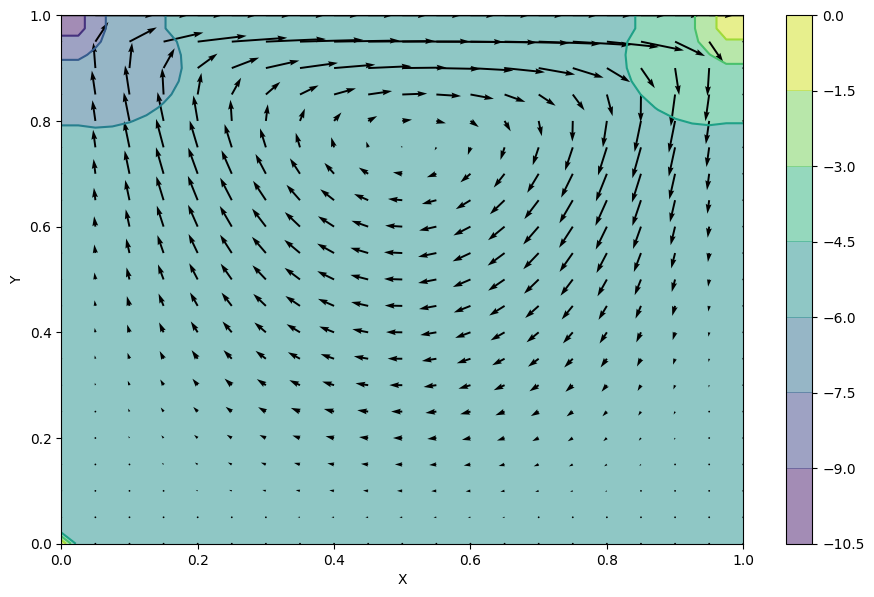

In [6]:
#NBVAL_IGNORE_OUTPUT
u = np.zeros((nx, ny))
v = np.zeros((nx, ny))
p = np.zeros((nx, ny))
b = np.zeros((nx, ny))
nt = 1000
# Store the output velocity and pressure fields in the variables a, b and c.
# This is so they do not clash with the devito outputs below.
a, b, c, d = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

fig = pyplot.figure(figsize=(11, 7), dpi=100)
pyplot.contourf(X, Y, c, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, c, cmap=cm.viridis)
pyplot.quiver(X[::2, ::2], Y[::2, ::2], a[::2, ::2], b[::2, ::2])
pyplot.xlabel('X')
pyplot.ylabel('Y');

### Validation

Marchi et al (2009)$^1$ compared numerical implementations of the lid driven cavity problem with their solution on a 1024 x 1024 nodes grid. We will compare a solution using both NumPy and Devito  with the results of their paper below.

1. https://www.scielo.br/scielo.php?pid=S1678-58782009000300004&script=sci_arttext

In [7]:
# Import u values at x=L/2 (table 6, column 2 rows 12-26) in Marchi et al.
Marchi_Re10_u = np.array([[0.0625, -3.85425800e-2],
                          [0.125,  -6.96238561e-2],
                          [0.1875, -9.6983962e-2],
                          [0.25,   -1.22721979e-1],
                          [0.3125, -1.47636199e-1],
                          [0.375,  -1.71260757e-1],
                          [0.4375, -1.91677043e-1],
                          [0.5,    -2.05164738e-1],
                          [0.5625, -2.05770198e-1],
                          [0.625,  -1.84928116e-1],
                          [0.6875, -1.313892353e-1],
                          [0.75,   -3.1879308e-2],
                          [0.8125,  1.26912095e-1],
                          [0.875,   3.54430364e-1],
                          [0.9375,  6.50529292e-1]])
# Import v values at y=L/2 (table 6, column 2 rows 27-41) in Marchi et al.
Marchi_Re10_v = np.array([[0.0625, 9.2970121e-2],
                          [0.125,  1.52547843e-1],
                          [0.1875, 1.78781456e-1],
                          [0.25,   1.76415100e-1],
                          [0.3125, 1.52055820e-1],
                          [0.375,  1.121477612e-1],
                          [0.4375, 6.21048147e-2],
                          [0.5,    6.3603620e-3],
                          [0.5625,-5.10417285e-2],
                          [0.625, -1.056157259e-1],
                          [0.6875,-1.51622101e-1],
                          [0.75,  -1.81633561e-1],
                          [0.8125,-1.87021651e-1],
                          [0.875, -1.59898186e-1],
                          [0.9375,-9.6409942e-2]])

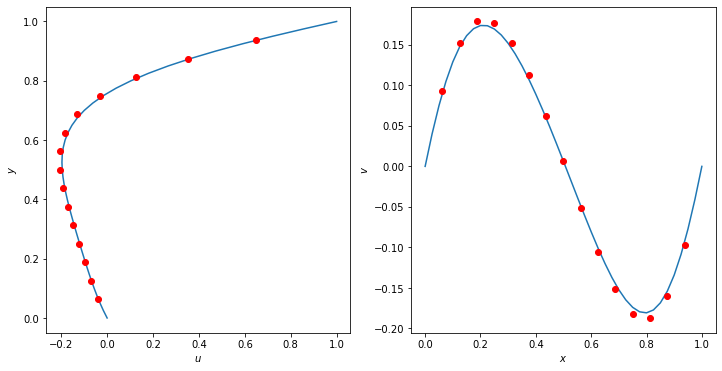

In [8]:
#NBVAL_IGNORE_OUTPUT
# Check results with Marchi et al 2009.
npgrid=[nx,ny]

x_coord = np.linspace(0, 1, npgrid[0])
y_coord = np.linspace(0, 1, npgrid[1])

fig = pyplot.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax1.plot(a[int(npgrid[0]/2),:],y_coord[:])
ax1.plot(Marchi_Re10_u[:,1],Marchi_Re10_u[:,0],'ro')
ax1.set_xlabel('$u$')
ax1.set_ylabel('$y$')
ax1 = fig.add_subplot(122)
ax1.plot(x_coord[:],b[:,int(npgrid[1]/2)])
ax1.plot(Marchi_Re10_v[:,0],Marchi_Re10_v[:,1],'ro')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$v$')

pyplot.show()

## Devito Implementation

In [9]:
from devito import Grid

grid = Grid(shape=(nx, ny), extent=(1., 1.))
x, y = grid.dimensions
t = grid.stepping_dim

Reminder: here are our equations

$$ \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y}= -\frac{1}{\rho}\frac{\partial p}{\partial x}  + \nu \left[ \frac{\partial^2 u}{\partial x^2} +\frac{\partial^2 u}{\partial y^2} \right] $$

$$ \frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y}= -\frac{1}{\rho}\frac{\partial p}{\partial y}  + \nu \left[ \frac{\partial^2 v}{\partial x^2} +\frac{\partial^2 v}{\partial y^2} \right] $$

$$
\frac{\partial^2 p}{\partial x^2} +\frac{\partial^2 p}{\partial y^2} =
\rho \left[\frac{\partial}{\partial t} \left(\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} \right) - \left(\frac{\partial u}{\partial x}\frac{\partial u}{\partial x}+2\frac{\partial u}{\partial y}\frac{\partial v}{\partial x}+\frac{\partial v}{\partial y}\frac{\partial v}{\partial y} \right) \right]
$$

Note that p has no time dependence, so we are going to solve for p in pseudotime then move to the next time step and solve for u and v. This will require two operators, one for p (using p and pn) in  pseudotime and one for u and v in time.

As shown in the Poisson equation tutorial, a TimeFunction can be used despite the lack of a time-dependence. This will cause Devito to allocate two grid buffers, which we can addressed directly via the terms pn and pn.forward. The internal time loop can be controlled by supplying the number of pseudotime steps (iterations) as a time argument to the operator.

The time steps are advanced through a Python loop where a separator operator calculates u and v.

Also note that we need to use first order spatial derivatives for the velocites and these derivatives are not the maximum spatial derivative order (2nd order) in these equations. This is the first time we have seen this in this tutorial series (previously we have only used a single spatial derivate order). 

   To use a first order derivative of a devito function, we use the syntax `function.dxc` or `function.dyc` for the x and y derivatives respectively.

In [10]:
from devito import TimeFunction, Function, \
Eq, solve, Operator, configuration

# Build Required Functions and derivatives:
# --------------------------------------
# |Variable | Required Derivatives     |
# --------------------------------------
# |   u     | dt, dx, dy, dx**2, dy**2 |
# |   v     | dt, dx, dy, dx**2, dy**2 |
# |   p     |     dx, dy, dx**2, dy**2 |
# |   pn    |     dx, dy, dx**2, dy**2 |
# --------------------------------------
u = TimeFunction(name='u', grid=grid, space_order=2)
v = TimeFunction(name='v', grid=grid, space_order=2)
p  = TimeFunction(name='p',  grid=grid, space_order=2)
#Variables are automatically initalized at 0.

# First order derivatives will be handled with p.dxc
eq_u =Eq(u.dt + u*u.dx + v*u.dy, -1./rho * p.dxc + nu*(u.laplace),  subdomain=grid.interior)
eq_v =Eq(v.dt + u*v.dx + v*v.dy, -1./rho * p.dyc + nu*(v.laplace),  subdomain=grid.interior)
eq_p =Eq(p.laplace,rho*(1./dt*(u.dxc+v.dyc)-(u.dxc*u.dxc)+2*(u.dyc*v.dxc)+(v.dyc*v.dyc)),  subdomain=grid.interior)

# NOTE: Pressure has no time dependence so we solve for the other pressure buffer.
stencil_u =solve(eq_u , u.forward)
stencil_v =solve(eq_v , v.forward)
stencil_p=solve(eq_p, p)
 
update_u =Eq(u.forward, stencil_u)
update_v =Eq(v.forward, stencil_v)
update_p =Eq(p.forward, stencil_p) 

# Boundary Conds. u=v=0 for all sides
bc_u  = [Eq(u[t+1, 0, y], 0)]  
bc_u += [Eq(u[t+1, nx-1, y], 0)]  
bc_u += [Eq(u[t+1, x, 0], 0)]  
bc_u += [Eq(u[t+1, x, ny-1], 1)]  # except u=1 for y=2
bc_v  = [Eq(v[t+1, 0, y], 0)]  
bc_v += [Eq(v[t+1, nx-1, y], 0)]  
bc_v += [Eq(v[t+1, x, ny-1], 0)]  
bc_v += [Eq(v[t+1, x, 0], 0)]  

bc_p  = [Eq(p[t+1, 0, y],p[t+1, 1,y])]  # dpn/dx = 0 for x=0.
bc_p += [Eq(p[t+1,nx-1, y],p[t+1,nx-2, y])]  # dpn/dx = 0 for x=2.
bc_p += [Eq(p[t+1, x, 0],p[t+1,x ,1])]  # dpn/dy = 0 at y=0
bc_p += [Eq(p[t+1, x, ny-1],p[t+1, x, ny-2])]  # pn=0 for y=2
bc_p += [Eq(p[t+1, 0, 0], 0)]
bc=bc_u+bc_v

optime=Operator([update_u, update_v]+bc_u+bc_v)
oppres=Operator([update_p]+bc_p)

In [11]:
# Silence non-essential outputs from the solver.
configuration['log-level'] = 'ERROR'


# This is the time loop.
for step in range(0,nt):
    if step>0:
        oppres(time_M = nit)
    optime(time_m=step, time_M=step, dt=dt)

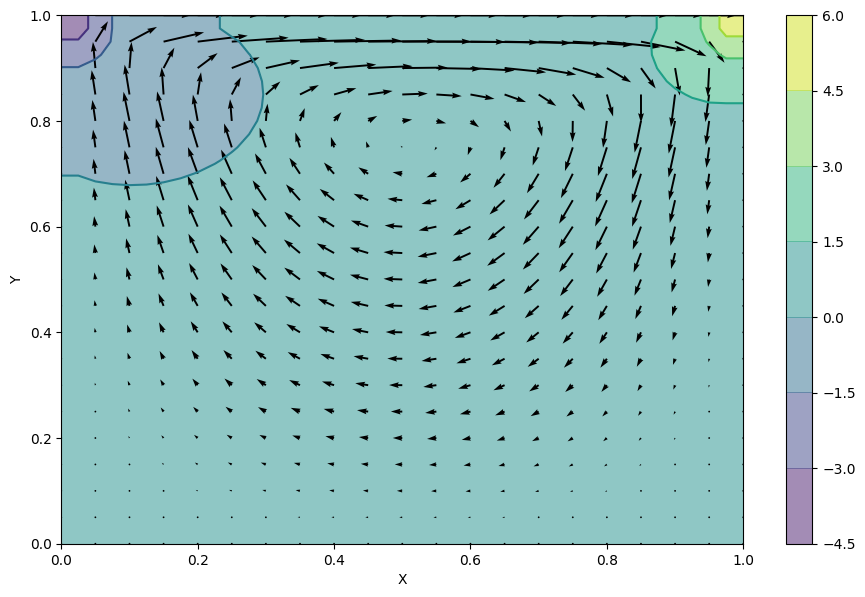

In [12]:
#NBVAL_IGNORE_OUTPUT
fig = pyplot.figure(figsize=(11,7), dpi=100)
# Plotting the pressure field as a contour.
pyplot.contourf(X, Y, p.data[0], alpha=0.5, cmap=cm.viridis)  
pyplot.colorbar()
# Plotting the pressure field outlines.
pyplot.contour(X, Y, p.data[0], cmap=cm.viridis)  
# Plotting velocity field.
pyplot.quiver(X[::2,::2], Y[::2,::2], u.data[0,::2,::2], v.data[0,::2,::2]) 
pyplot.xlabel('X')
pyplot.ylabel('Y');


### Validation

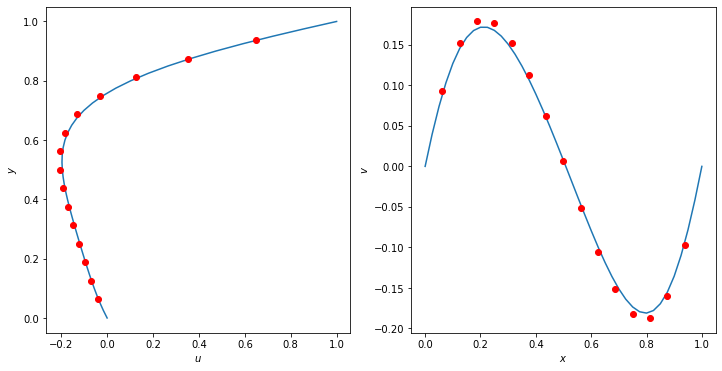

In [13]:
#NBVAL_IGNORE_OUTPUT
# Again, check results with Marchi et al 2009.
fig = pyplot.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax1.plot(u.data[0,int(grid.shape[0]/2),:],y_coord[:])
ax1.plot(Marchi_Re10_u[:,1],Marchi_Re10_u[:,0],'ro')
ax1.set_xlabel('$u$')
ax1.set_ylabel('$y$')
ax1 = fig.add_subplot(122)
ax1.plot(x_coord[:],v.data[0,:,int(grid.shape[0]/2)])
ax1.plot(Marchi_Re10_v[:,0],Marchi_Re10_v[:,1],'ro')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$v$')

pyplot.show()


The Devito implementation produces results consistent with the benchmark solution. There is a small disparity in a few of the velocity values, but this is expected as the Devito 41 x 41 node grid is much coarser than the benchmark on a 1024 x 1024 node grid.


## Comparison

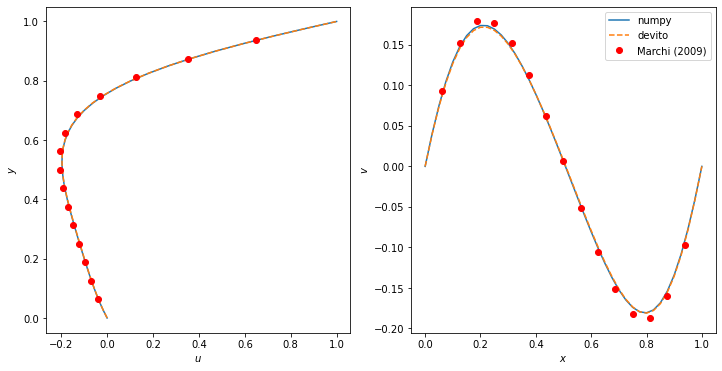

In [14]:
#NBVAL_IGNORE_OUTPUT
fig = pyplot.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax1.plot(a[int(npgrid[0]/2),:],y_coord[:])
ax1.plot(u.data[0,int(grid.shape[0]/2),:],y_coord[:],'--')
ax1.plot(Marchi_Re10_u[:,1],Marchi_Re10_u[:,0],'ro')
ax1.set_xlabel('$u$')
ax1.set_ylabel('$y$')
ax1 = fig.add_subplot(122)
ax1.plot(x_coord[:],b[:,int(npgrid[1]/2)])
ax1.plot(x_coord[:],v.data[0,:,int(grid.shape[0]/2)],'--')
ax1.plot(Marchi_Re10_v[:,0],Marchi_Re10_v[:,1],'ro')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$v$')
ax1.legend(['numpy','devito','Marchi (2009)'])

pyplot.show()

#Pressure norm check
tol = 1e-3
assert np.sum((c[:,:]-d[:,:])**2/ np.maximum(d[:,:]**2,1e-10)) < tol
assert np.sum((p.data[0]-p.data[1])**2/np.maximum(p.data[0]**2,1e-10)) < tol

Overlaying all the graphs together shows how the Devito, NumPy and Marchi et al (2009)$^1$ 
 solutions compare with each other. A final accuracy check is done which is to test whether the pressure norm has exceeded a specified tolerance.